
## Spin glass $N=14$
 

In [1]:
import itertools
import os

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
n = 14 
circ_depths = np.asarray([1,2])
algs = np.asarray(["qaoa", "qaoa+", "vqe"])
seeds = np.arange(1, 31)

#model_info = [(n, algo, p, seed) for p in circ_depths for algo in algs for seed in seeds]

In [3]:
jobs_df = pd.read_csv("data_n14_spinglass.csv")

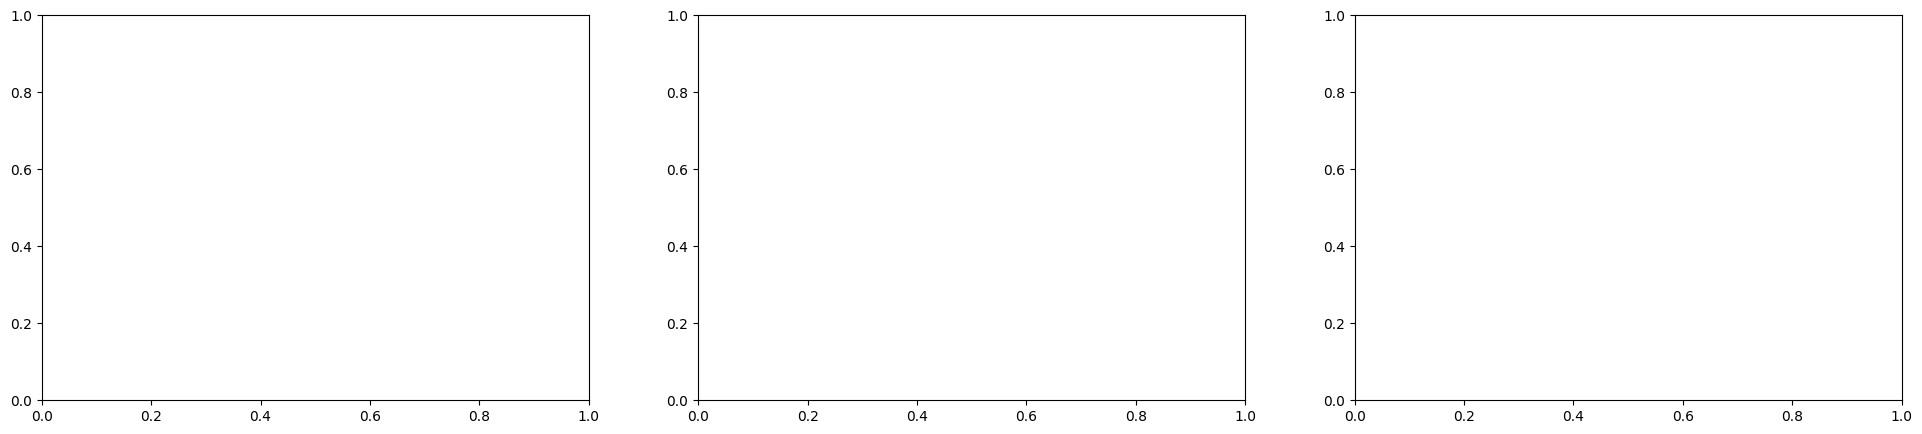

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 5))
for shot, data in jobs_df.groupby('shots'):
    if shot != 512:
        continue

    boxplot_data = []
    for it in np.arange(5,40,5):
        boxplot_data.append(data[(jobs_df['algo'] == 'qaoa') & (data['iter'] == it)]['p_succ'])
    ax1.boxplot(boxplot_data)
    ax1.set_title(f"QAOA shots={shot}")
    ax1.set_xticks(np.arange(8), np.arange(0,40,5))
    ax1.set_xlabel("iterations")
    ax1.set_ylabel(r"$F('success')$")

    boxplot_data = []
    for it in np.arange(5,40,5):
        boxplot_data.append(data[(jobs_df['algo'] == 'qaoa+') & (data['iter'] == it)]['p_succ'])
    ax2.boxplot(boxplot_data)
    ax2.set_title(f"QAOA+ shots={shot}")
    ax2.set_xticks(np.arange(8), np.arange(0,40,5))
    ax2.set_ylim(0,1)
    ax2.set_xlabel("iterations")
    ax2.set_ylabel(r"$F('success')$")
 
    boxplot_data = []
    for it in np.arange(5,40,5):
        boxplot_data.append(data[(jobs_df['algo'] == 'vqe') & (data['iter'] == it)]['p_succ'])
    ax3.boxplot(boxplot_data)
    ax3.set_title(f"VQE shots={shot}")
    ax3.set_xticks(np.arange(8), np.arange(0,40,5))
    ax3.set_ylim(0,1)
    ax3.set_xlabel("iterations")
    ax3.set_ylabel(r"$F('success')$")

plt.savefig("boxplot_shot512.png")

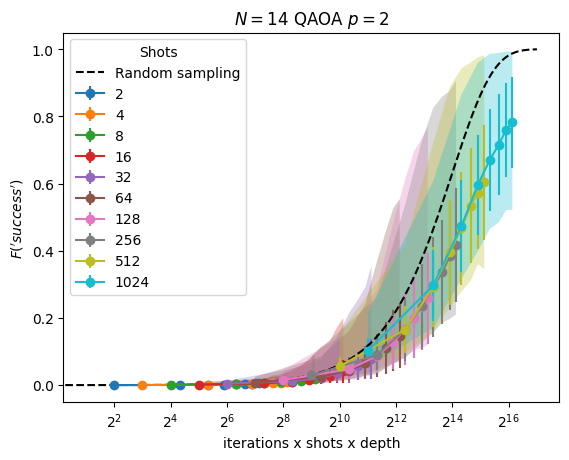

In [18]:
for shot, data in jobs_df[(jobs_df['algo'] == 'qaoa') & (jobs_df['iter'] < 37)].groupby('shots'):
    x_axes = data[data['seed'] == 1]['t']*data[data['seed'] == 1]["circ_depth"]
    y_axes = data.groupby(['iter'])['p_succ'].mean()
    error = data.groupby(['iter'])['p_succ'].std()

    plt.errorbar(x_axes, y_axes, yerr=data.groupby(['iter'])['p_succ'].std(), marker="o", label=f"{shot}")
    plt.fill_between(x_axes, data.groupby(['iter'])['p_succ'].min(), data.groupby(['iter'])['p_succ'].max(), alpha=0.3)

plt.plot(np.arange(0,2**(3+n),2), 1 - (1-1/(2**n))**np.arange(0,2**(3+n),2), '--', color="black", label="Random sampling")
plt.xscale("log", base=2)

plt.xlabel("iterations x shots x depth")
plt.ylabel(r"$F('success')$")

plt.title(f"$N=14$ QAOA $p=2$")
plt.legend(title='Shots')
plt.savefig("n14_spinglass_qaoap2.png")
    #print(data[data['seed'] == 1]['t'])

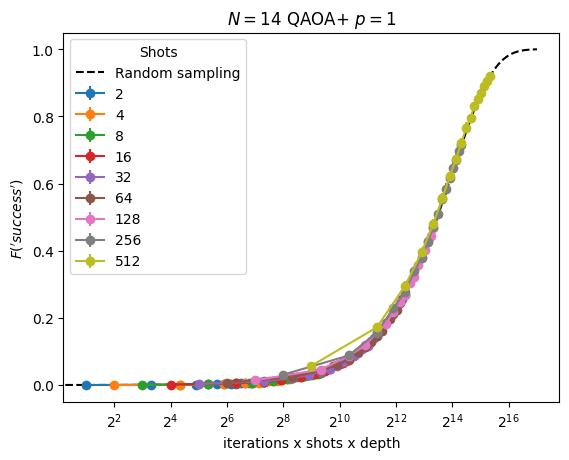

In [13]:
for shot, data in jobs_df[(jobs_df['algo'] == 'qaoa+')].groupby('shots'):
    plt.errorbar(data[data['seed'] == 1]['t'], data.groupby(['iter'])['p_succ'].mean(), yerr=data.groupby(['iter'])['p_succ'].std(), marker="o", label=f"{shot}")

plt.plot(np.arange(0,2**(3+n),2), 1 - (1-1/(2**n))**np.arange(0,2**(3+n),2), '--', color="black", label="Random sampling")
plt.xscale("log", base=2)

plt.xlabel("iterations x shots x depth")
plt.ylabel(r"$F('success')$")

plt.title(f"$N=14$ QAOA+ $p=1$")
plt.legend(title='Shots')
plt.savefig("n14_spinglass_qaoap+2.png")


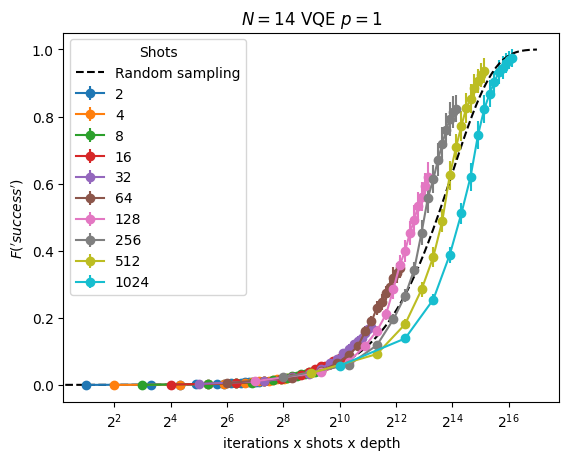

In [14]:
for shot, data in jobs_df[(jobs_df['algo'] == 'vqe')].groupby('shots'):
    plt.errorbar(data[data['seed'] == 1]['t'], data.groupby(['iter'])['p_succ'].mean(), yerr=data.groupby(['iter'])['p_succ'].std(), marker="o", label=f"{shot}")

plt.plot(np.arange(0,2**(3+n),2), 1 - (1-1/(2**n))**np.arange(0,2**(3+n),2), '--', color="black", label="Random sampling")
plt.xscale("log", base=2)

plt.xlabel("iterations x shots x depth")
plt.ylabel(r"$F('success')$")

plt.title(f"$N=14$ VQE $p=1$")
plt.legend(title='Shots')
plt.savefig("n14_spinglass_vqep1.png")



## Spin glass $4 \leq N \leq 12$

In [1]:
import itertools
import os

import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
jobs_df = pd.read_csv("data_spinglass-ALL.csv")

In [3]:
circ_depths = np.asarray([1,2])
algs = np.asarray(["qaoa", "qaoa+", "vqe"])
seeds = np.arange(1, 31)

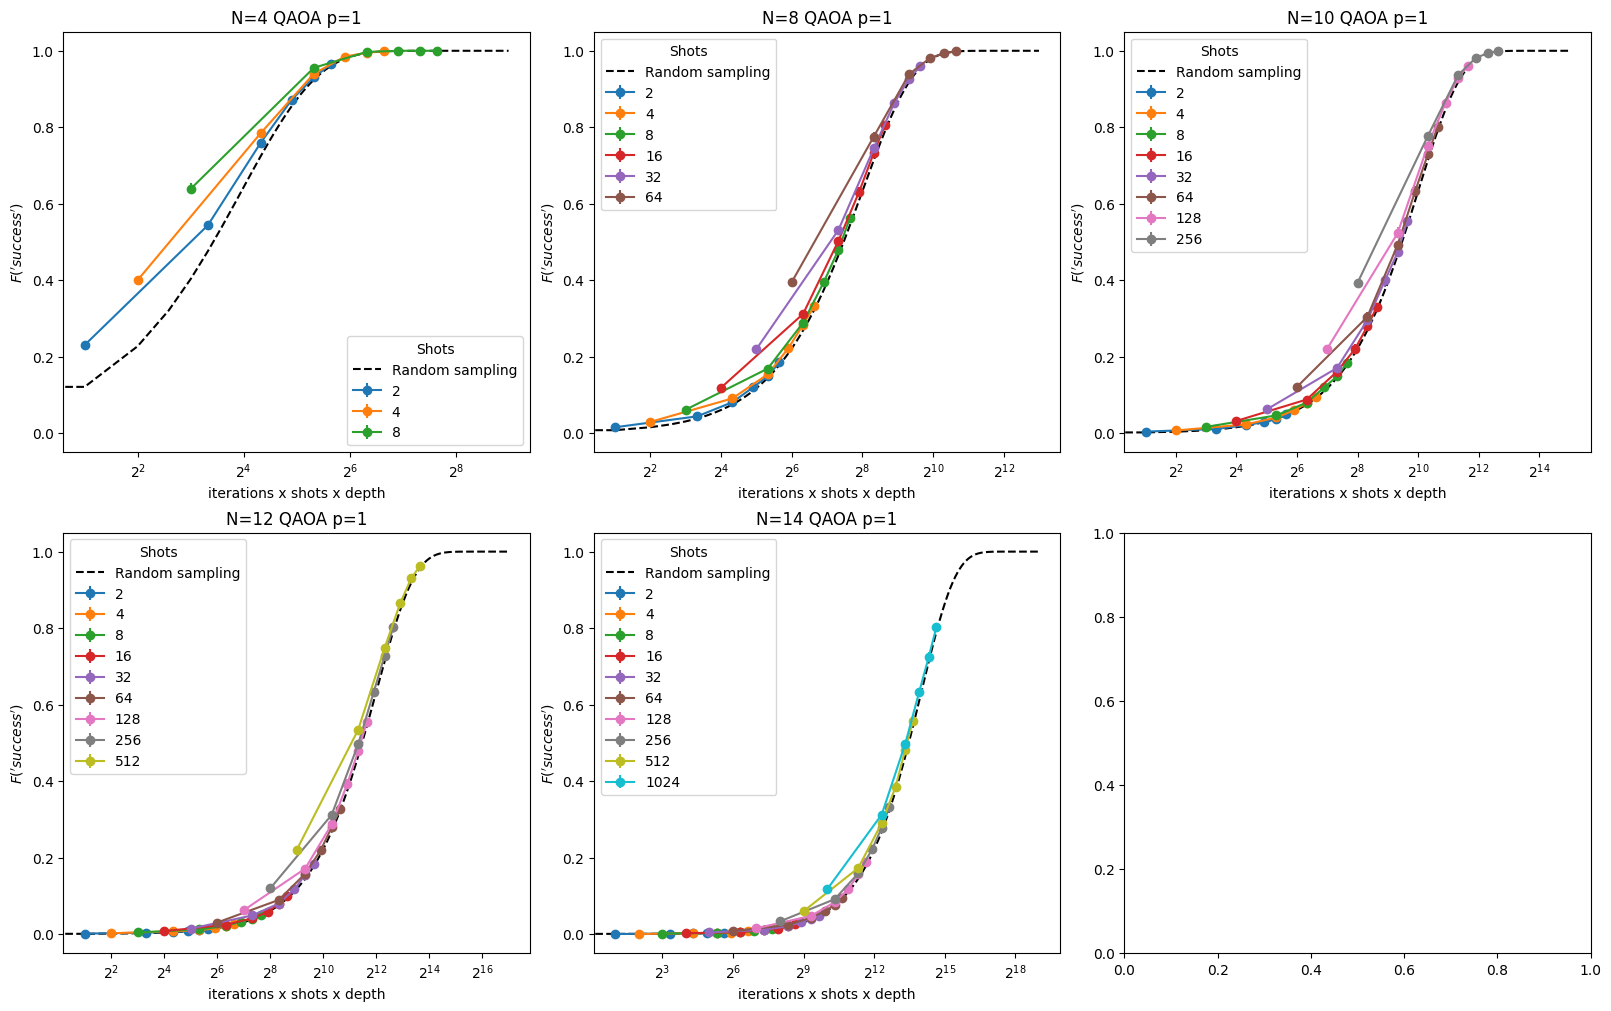

In [14]:
p = 1

fig = plt.figure(constrained_layout=True, figsize=(16,10))
subplots = fig.subplots(2,3)
for (qubits, data), subplot in zip(jobs_df[(jobs_df['algo'] == 'qaoa') & (jobs_df['circ_depth'] == p) & (jobs_df['iter'] <= 25)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        x_axes = dat[dat['seed'] == 1]['t']*dat[dat['seed'] == 1]["circ_depth"]
        y_axes = dat.groupby(['iter'])['p_succ'].median()
        error = [
            (dat.groupby(['iter'])['p_succ'].median() - dat.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
            (dat.groupby(['iter'])['p_succ'].quantile(0.75) - dat.groupby(['iter'])['p_succ'].median()).tolist(),
            ]

        subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
        #subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].min(), dat.groupby(['iter'])['p_succ'].max(), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black", label="Random sampling")
    subplot.set_xscale("log", base=2)

    subplot.set_xlabel("iterations x shots x depth")
    subplot.set_ylabel(r"$F('success')$")

    subplot.set_title(f"N={qubits} QAOA p={p}")
    subplot.legend(title='Shots')

plt.savefig('spinglass_all.png')
    # plt.show()

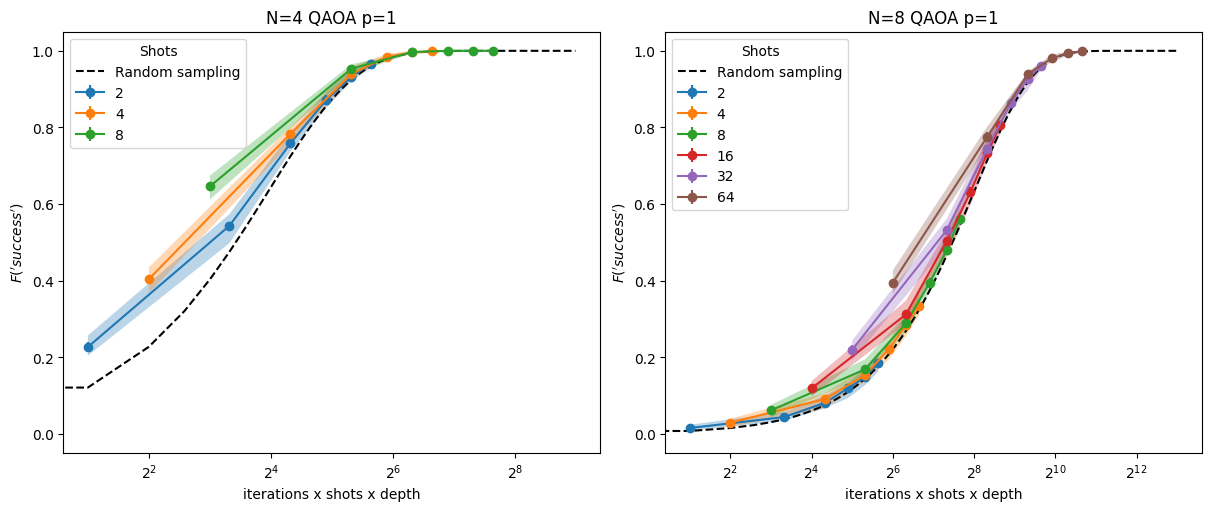

In [16]:
jobs_correct = pd.read_csv("data-n4-8_spinglass-PART.csv")

fig = plt.figure(constrained_layout=True, figsize=(12,5))
subplots = fig.subplots(1,2)
for (qubits, data), subplot in zip(jobs_correct[(jobs_correct['algo'] == 'qaoa') & (jobs_correct['circ_depth'] == 1) & (jobs_correct['iter'] <= 25)].groupby('qubits'), subplots):
    for shot, dat in data.groupby('shots'):
        x_axes = dat[dat['seed'] == 1]['t']*dat[dat['seed'] == 1]["circ_depth"]
        y_axes = dat.groupby(['iter'])['p_succ'].median()
        error = [
            (dat.groupby(['iter'])['p_succ'].median() - dat.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
            (dat.groupby(['iter'])['p_succ'].quantile(0.75) - dat.groupby(['iter'])['p_succ'].median()).tolist(),
            ]
        subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
        subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].min(), dat.groupby(['iter'])['p_succ'].max(), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black", label="Random sampling")
    subplot.set_xscale("log", base=2)

    subplot.set_xlabel("iterations x shots x depth")
    subplot.set_ylabel(r"$F('success')$")

    subplot.set_title(f"N={qubits} QAOA p=1")
    subplot.legend(title='Shots')

plt.savefig('spinglass_correct.png')

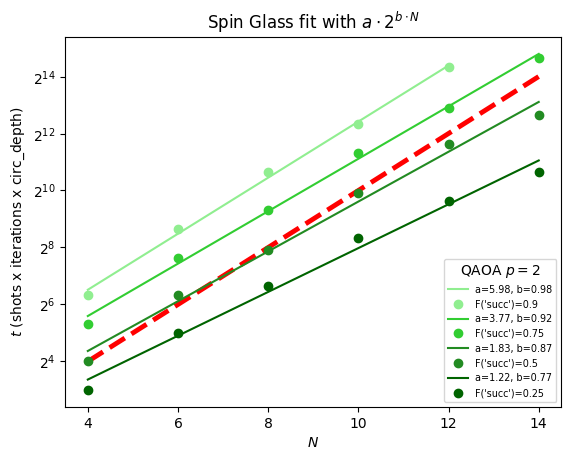

In [11]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

min_qubits, max_qubits = 4, 14

fig = plt.figure()

plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

p_tresholds = [0.9, 0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
for p, color in zip(p_tresholds, colors):
    median_for_seed = jobs_df[(jobs_df['algo'] == 'qaoa') & (jobs_df['circ_depth'] == 2) & (jobs_df['qubits'] > 2)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
    gt_p = median_for_seed[median_for_seed['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    popt, _ = optimize.curve_fit(fun_lin, gt_p['qubits'], np.log2(gt_p['t']*median_for_seed['circ_depth'][0]))
    plt.plot(gt_p['qubits'], fun_exp(gt_p['qubits'], 2**popt[0], popt[1]), "-", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    
    plt.plot(gt_p['qubits'], gt_p['t']*median_for_seed['circ_depth'][0], "o", label=f"F('succ')={p}", color=color)

    plt.yscale('log', base=2)
    plt.ylabel(r"$t$ (shots x iterations x circ_depth)")
    plt.xlabel(r"$N$")

plt.legend(loc='lower right', title=r"QAOA $p=2$", fontsize="x-small")

plt.title(r"Spin Glass fit with $a \cdot 2^{b \cdot N}$")

plt.savefig("scale_spinglass.png")

/home/beppe/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/beppe/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/beppe/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/beppe/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/beppe/miniconda3/envs/cvar/lib/python3.10/site

Text(0.5, 1.0, 'Spin Glass fit with $a \\cdot 2^{b \\cdot N}$')

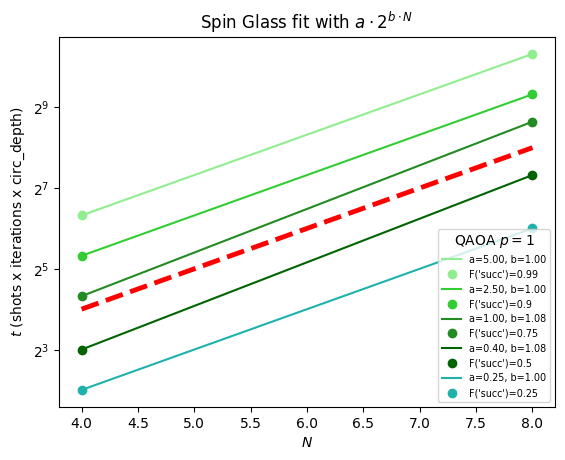

In [19]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

min_qubits, max_qubits = 4, 8

fig = plt.figure()

plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

p_tresholds = [0.99, 0.9, 0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
for p, color in zip(p_tresholds, colors):
    median_for_seed = jobs_correct[(jobs_correct['algo'] == 'qaoa') & (jobs_correct['circ_depth'] == 1)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
    gt_p = median_for_seed[median_for_seed['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    popt, _ = optimize.curve_fit(fun_lin, gt_p['qubits'], np.log2(gt_p['t']*median_for_seed['circ_depth'][0]))
    plt.plot(gt_p['qubits'], fun_exp(gt_p['qubits'], 2**popt[0], popt[1]), "-", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    
    plt.plot(gt_p['qubits'], gt_p['t']*median_for_seed['circ_depth'][0], "o", label=f"F('succ')={p}", color=color)

    plt.yscale('log', base=2)
    plt.ylabel(r"$t$ (shots x iterations x circ_depth)")
    plt.xlabel(r"$N$")

plt.legend(loc='lower right', title=r"QAOA $p=1$", fontsize="x-small")

plt.title(r"Spin Glass fit with $a \cdot 2^{b \cdot N}$")

In [37]:
jobs_df[(jobs_df['algo'] == 'qaoa')].head()

,Unnamed: 0,t,shots,iter,p_succ,qubits,circ_depth,algo,seed
9090,9090,2,2,1,0.190,4,2,qaoa,1
9091,9091,10,2,5,0.506,4,2,qaoa,1
9092,9092,20,2,10,0.718,4,2,qaoa,1
9093,9093,30,2,15,0.821,4,2,qaoa,1
9094,9094,40,2,20,0.895,4,2,qaoa,1


In [ ]:
prendere varianza dei parametri e mettila come errorbar
cambiare nome del QAOA+ con meno oppure like
attenzione a qaoa, inserire Rz (ext_field)
g100-scratch path dove salvare


## Check ansatz


In [2]:
import itertools
import os

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import qiskit

from src import utils

In [ ]:
qc = utils.create_ansatz(4, 1, 'qaoa')
print(qc)


## Process raw data


In [8]:
import itertools
import os
import math

import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt

In [12]:
dims = [12,14]
circ_depths = [1,2]
algs = ["qaoa", "qaoa+", "vqe"]
seeds = np.arange(1, 31)


model_info = [(n, algo, p, seed) for p in circ_depths for algo in algs for n in dims for seed in seeds] 

In [13]:
run_info = {"t": [], "shots": [], "iter": [], "p_succ": [], "qubits": [], "circ_depth": [], "algo": [], "seed": []}
for (n, algo, p, seed) in model_info:
    dir_path = f"results/N{n}/{algo}p{p}_{seed}/"
    if not os.path.isdir(dir_path):
        #print(f"{dir_path} does not exist")
        continue
    for filename in sorted(os.listdir(dir_path)):
        filename = dir_path + filename
        with open(filename, "r") as file:
            # data are a list with #initial_points elements
            runs = json.load(file)
        ever_founds = []
        iterations = [] 
        # for each shot and iteration param
        # we randomized the initial point
        # to estimate the right probability
        for r in runs:
            ever_founds.append(bool(r["ever_found"]))
            iterations.append(r["nfev"])
        # compute p('found minimum')
        #run_info["p_succ"].append(ever_founds)
        run_info["p_succ"].append(
            np.mean(ever_founds, dtype=np.float128 )
        )  # float128 to avoid to many zeros
        run_info["iter"].append(int(math.ceil(np.mean(iterations))))
        # maxiter*shots = actual number of iteration
        run_info["t"].append(r["shots"] * run_info["iter"][-1])
        run_info["shots"].append(r["shots"])
        run_info["qubits"].append(n)
        run_info["circ_depth"].append(p)
        run_info["algo"].append(algo)
        run_info["seed"].append(seed)
        
jobs_df = pd.DataFrame(run_info)
jobs_df.to_csv(f"data_n14-12_PART.csv")

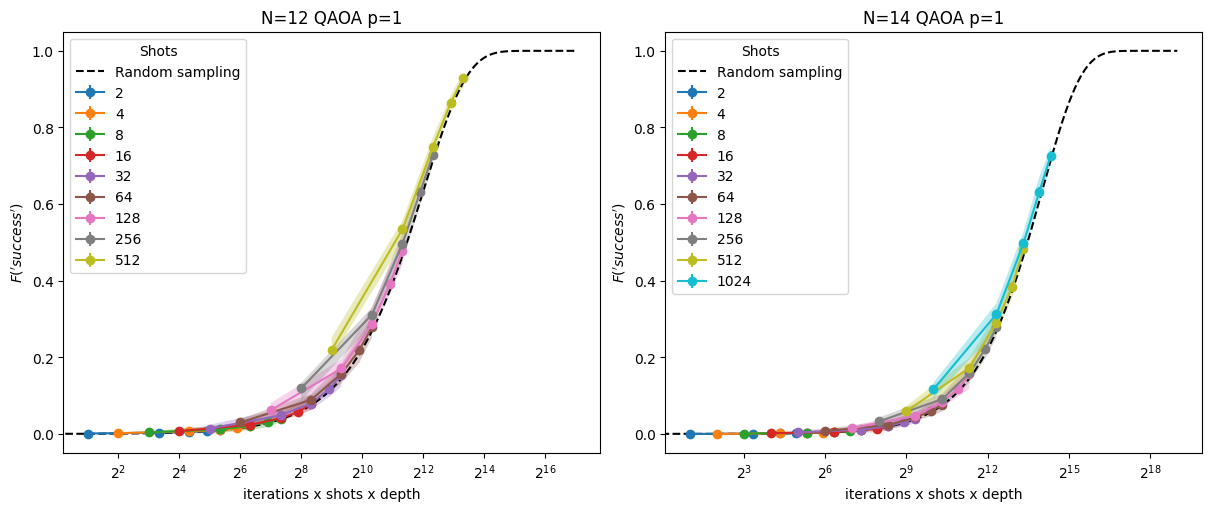

In [49]:
jobs_correct = pd.read_csv("data_n14-12_PART.csv")

fig = plt.figure(constrained_layout=True, figsize=(12,5))
subplots = fig.subplots(1,2)
for (qubits, data), subplot in zip(jobs_correct[(jobs_correct['algo'] == 'qaoa') & (jobs_correct['circ_depth'] == 1) & (jobs_correct['iter'] < 25)].groupby('qubits'), subplots):
    for shot, dat in data.groupby('shots'):
        x_axes = dat[dat['seed'] == 1]['t']*dat[dat['seed'] == 1]['circ_depth'].mean()
        y_axes = dat.groupby(['iter'])['p_succ'].median()
        error = [
            (dat.groupby(['iter'])['p_succ'].median() - dat.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
            (dat.groupby(['iter'])['p_succ'].quantile(0.75) - dat.groupby(['iter'])['p_succ'].median()).tolist(),
            ]
        subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
        subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].min(), dat.groupby(['iter'])['p_succ'].max(), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black", label="Random sampling")
    subplot.set_xscale("log", base=2)

    subplot.set_xlabel("iterations x shots x depth")
    subplot.set_ylabel(r"$F('success')$")

    subplot.set_title(f"N={qubits} QAOA p={int(dat[dat['seed'] == 1]['circ_depth'].mean())}")
    subplot.legend(title='Shots')

plt.savefig('spinglass_p1.png')

/home/beppe/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/beppe/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/beppe/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


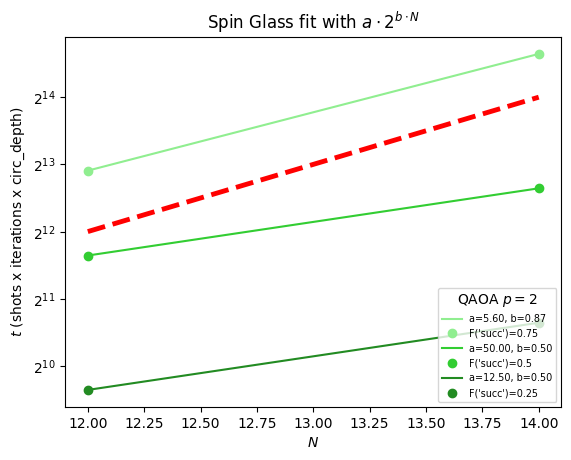

In [52]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

min_qubits, max_qubits = 12, 14

fig = plt.figure()

plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

p_tresholds = [0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
for p, color in zip(p_tresholds, colors):
    median_for_seed = jobs_correct[(jobs_correct['algo'] == 'qaoa') & (jobs_correct['circ_depth'] == 2)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
    gt_p = median_for_seed[median_for_seed['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    popt, _ = optimize.curve_fit(fun_lin, gt_p['qubits'], np.log2(gt_p['t']*median_for_seed['circ_depth'][0]))
    plt.plot(gt_p['qubits'], fun_exp(gt_p['qubits'], 2**popt[0], popt[1]), "-", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    
    plt.plot(gt_p['qubits'], gt_p['t']*median_for_seed['circ_depth'][0], "o", label=f"F('succ')={p}", color=color)

    plt.yscale('log', base=2)
    plt.ylabel(r"$t$ (shots x iterations x circ_depth)")
    plt.xlabel(r"$N$")

plt.legend(loc='lower right', title=r"QAOA $p=2$", fontsize="x-small")

plt.title(r"Spin Glass fit with $a \cdot 2^{b \cdot N}$")
plt.savefig('scaling_p2.png')